# Predict unseen variants using global epistasis models

In this example, we simulate deep mutational scanning libraries with a variety of mutation rates, assuming the variant phenotypes can be described by a global epistasis model.
We then fit a global epistasis model to the data, and see how well we are able to estimate the latent effects of mutations.
Finally, we test how well the models fit to the data can predict the phenotypes of new *unseen* multiple-mutant variants.

So overall, the example is designed to address the following questions:

 1. How well can fitting global epistasis models predict variant phenotypes (assuming the variants are actually describable by these models)?
 2. What is the optimal mutation rate for a deep mutational scanning library if we want to predict the phenotypes of unseen variants?

## Setup for analysis

Import Python modules / packages:

In [1]:
import random
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Now we set the parameters that define the simulation.
We try to choose parameters typical of a Bloom lab viral deep mutational scanning project.
There is a modest rate of errors in the variant calling, and a moderate bottleneck going from pre- to post-selection.
We use a reasonably long gene (several hundred codons) as the results might be different for realistic-sized proteins compared to the "mini-proteins" used in some of the other examples.
Crucially, we test libraries with a variety of mutation rates (average number of codon substitutions per variant):

In [2]:
seed = 1  # random number seed
genelength = 300  # gene length in codons
variants_per_lib = 300 * genelength  # variants per library
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 100  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottleneck = 10  # bottleneck from pre- to post-selection as multiple of variants_per_lib

# Try libraries with a variety of mutation rates, defined
# as average codon mutations per variant.
avgmuts_list = [1.0, 2.0, 3.0, 4.0, 5.0]

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate libraries of codon variants with each of the average mutation rates.

Simulate wildtype gene sequence:

In [7]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 300 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGACAGGATTCTTCCCTGGATAAGATGTACCGCAGGGACGGGGGCCCGCGGCTTGTTCTTCCTCTCAACAAGGGGTTGGCACGAAGGCTGTTGGTTGAATCGATGCTTTTCGATCTACAAGACTTCAAAGTTTCATGCGTCTATCTTGAGCGCAATTCTGAGATACTGCTCCCCCCCGAAGCGGCCCGTAACATGAGGGATTCGTACTACTATATTTCCGGCACCAACAAAGTGATTACGGCGCCCACAAGCGAAAGGCAAGGTCGTCATCTAAACCCTCGCAGTACGTGCCTTATAGCATATAACAACAGAGGTAGCGGGGGCGACATCTTGTACCTTATCGCTCGAGATCATGCGAATCAGTTGTCTCAGTCGCAGTTAGTCCGCATTAAATCTAAGTATTTCGAGAGGTCGTTGGGGCTTCCTCCCATAGGCCGGAGTACGGGACAGCTGCATTCTTGCAACATACATTTTGTTCCAATAGGCTCCTGTCCATCTGGCCTCTTTATGGTAACCAGGTGGATAGTGGCATCCCCGCCACACTCGGCATTCTGCAGAGACACGAAGACATCGTACTCACCAGCCGTTCCTGAGATCACACAATGCGAGTGTCGTCAATACTCAAAAGGAACCACTTCTAAGATGTTTCGCACTAGGATGGTCACGTGGCCTTTGTGGCACATTCTCACGGCTAAGAAATTGCAGGCACGTCATAATTGGTTGTTGACGATCGCCTTGGACGGCGGAATTGAC


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function, with different libraries for each mutation rate:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={f"<m> = {avgmuts:.1f}": {'avgmuts': avgmuts,
                                                         'nvariants': variants_per_lib}
                               for avgmuts in avgmuts_list},
                seed=seed,
                )

Plot the number of amino-acid mutations per variant:

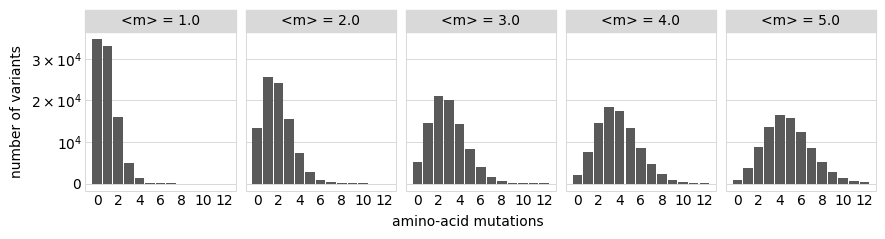

In [9]:
p = variants.plotNumMutsHistogram('aa',
                                  samples=None,
                                  libraries=variants.libraries,
                                  max_muts=round(2.5 * max(avgmuts_list)),
                                  widthscale=1.2,
                                  )
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of codon mutations of each type per variant:

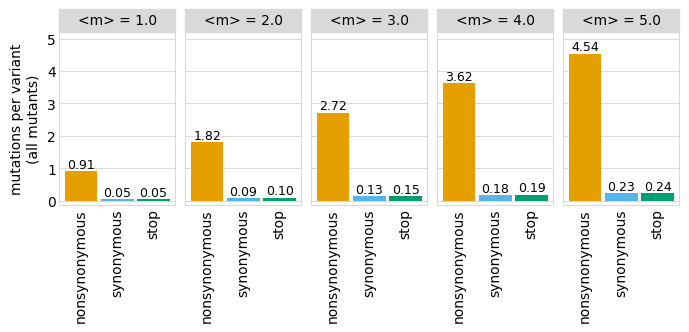

In [10]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    libraries=variants.libraries)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times, making separate plots for single mutants and all mutants.
As expected, the libraries with lower mutation rates sample mutations somewhat better among **single**-mutant variants, but much worse among all variants.

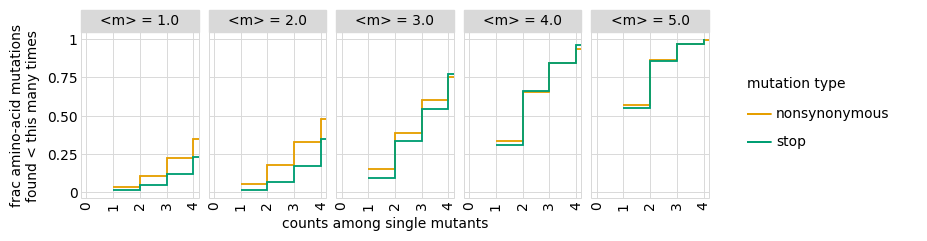

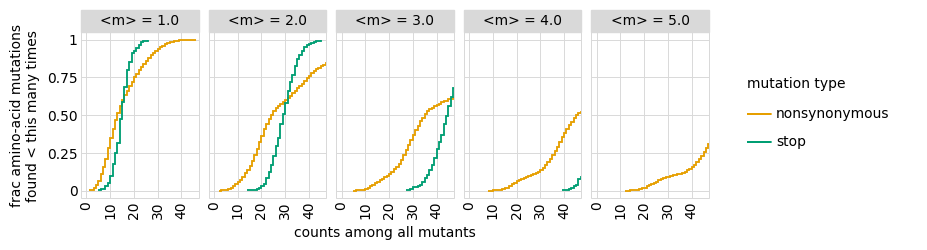

In [11]:
for variant_type in ['single', 'all']:
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type='aa',
                                      samples=None,
                                      libraries=variants.libraries)
    _ = p.draw()

## Simulate counts for samples
Now we simulate the counts of each variant after selection.

First, we define a “phenotype” function using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator),
which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in
two steps: an underlying latent phenotype that mutations affect additively, and
then an observed phenotype that is a non-linear
function of the latent phenotype.
The variants are then simulated according to their observed enrichments, which are the exponentials of the observed phenotypes:

In [12]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                            geneseq,
                                            seed=seed,
                                            wt_latent=4,
                                            stop_effect=-10,
                                            norm_weights=((0.35, -1.25, 1.25),
                                                          (0.65, -5.5, 2.25))
                                            )

Plot the simulated relationship of the latent phenotype with the observed enrichment and phenotype, with a dashed
vertical line indicating the wildtype latent phenotype:

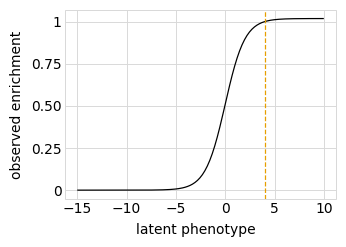

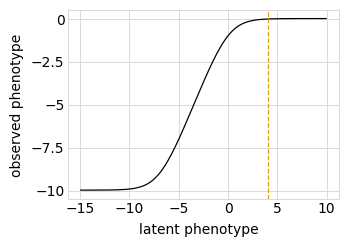

In [13]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot the latent phenotype, observed phenotype, and observed enrichment of all single amino-acid mutants, with a
dashed vertical line indicating the wildtype:

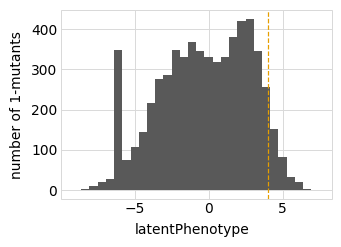

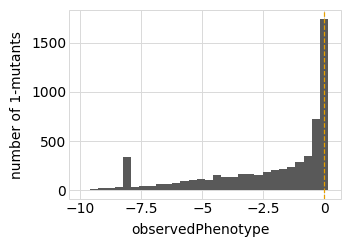

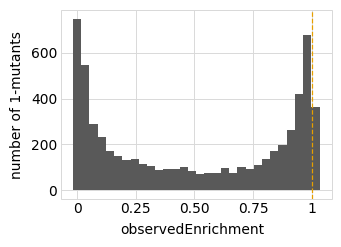

In [14]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

Use [simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts) to simulate counts of variants when selection on each variant is proportional to
its observed enrichment:

In [15]:
counts = dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={'total_count': variants_per_lib * avgdepth_per_variant,
                    'uniformity': lib_uniformity},
        pre_sample_name='pre-selection',
        post_samples={'post-selection': 
                          {'noise': noise,
                           'total_count': variants_per_lib * avgdepth_per_variant,
                           'bottleneck': variants_per_lib * bottleneck}
                      },
        seed=seed,
        )

Add the simulated counts for each library to the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [16]:
variants.add_sample_counts_df(counts)

Plot the number of counts for each variant in each sample. 
The horizontal
dashed line shows the total number of variants. 
The plot shows that all
variants are well-sampled in the pre-selection libraries, but that post-
selection some variants are sampled more or less.
This is expected since
selection will decrease and increase the frequency of variants:

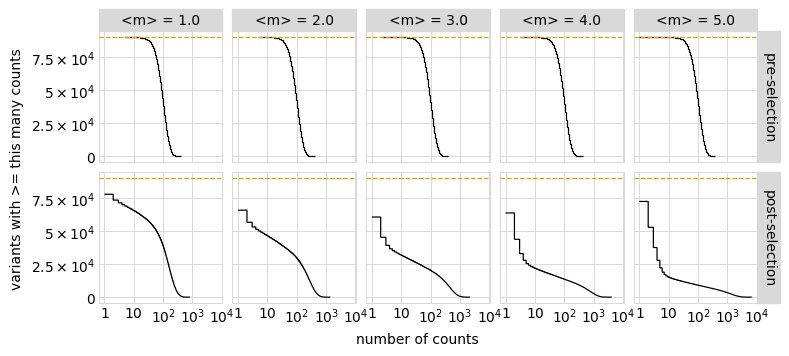

In [17]:
p = variants.plotCumulVariantCounts(libraries=variants.libraries)
_ = p.draw()

Distribution of the number of amino-acid mutations per variant in each sample.
As expected, mutations go down after selection:

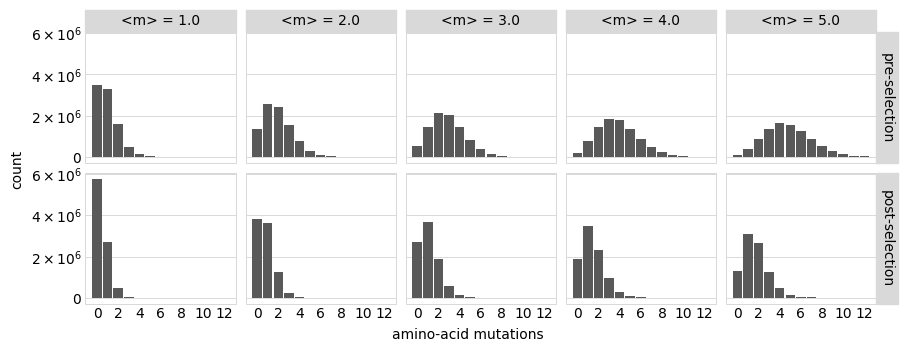

In [18]:
p = variants.plotNumMutsHistogram(mut_type='aa',
                                  libraries=variants.libraries,
                                  max_muts=round(2.5 * max(avgmuts_list)),
                                  widthscale=1.2)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of mutations per variant:

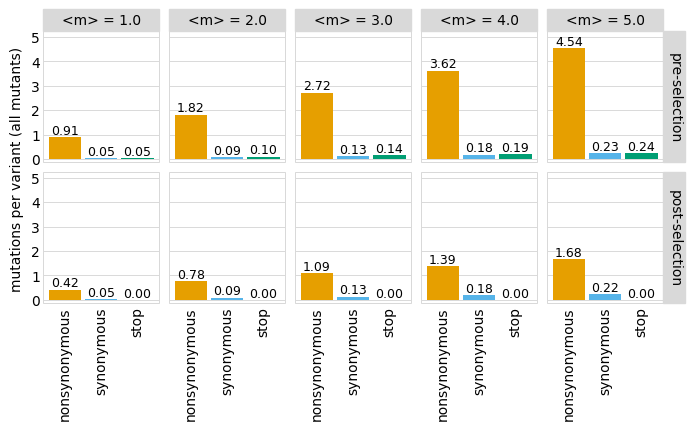

In [19]:
p = variants.plotNumCodonMutsByType(variant_type='all',
                                    libraries=variants.libraries)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Functional scores for variants
Use
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
to calculates a functional score for each variant based on its change in
frequency from pre- to post-selection:

In [20]:
func_scores = variants.func_scores('pre-selection',
                                   libraries=variants.libraries)

Classify variants
by the “types” of mutations they
have using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants):

In [21]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(func_scores)

Plot the distributions of scores, coloring by the variant class.
As expected, the multiple amino-acid mutant variants tend to have lower scores for the libraries with higher mutation rates, since in those libraries the multiple mutants tend to have more mutations (which are generally deleterious):

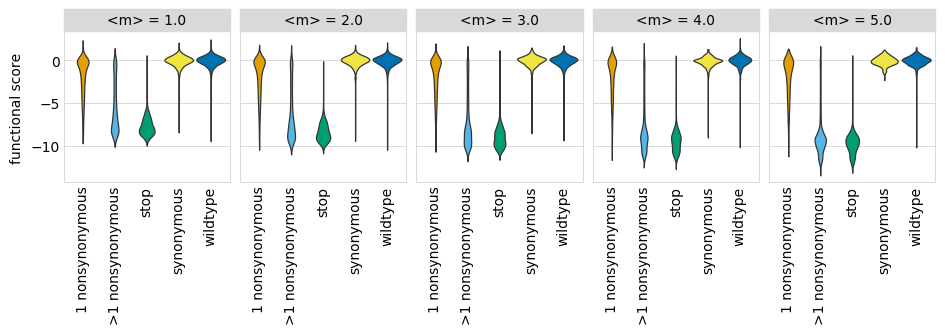

In [22]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_wrap('~ library', nrow=1) +
    theme(figure_size=(2.25 * len(variants.libraries), 2),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Fit global epistasis models
Now we fit global epistasis models.

We fit two different types of epistasis functions:
 - [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) models, which model global epistasis in the way described in [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
 - [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) models, which assume mutations contribute additively to the functional scores.

We just use one way to calculate the likelihood, the [GaussianLikelihood](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.GaussianLikelihood). 
That's because this likelihood calculation method words best for experiments with only modest noise like the one simulated here.
If you had more experimental noise, you might also try the [CauchyLikelihood](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.GaussianLikelihood), which is more robust to noise.
 
See the [globalepistasis module documentation](https://jbloomlab.github.io/dms_variants/codonvariant_sim_data.html) for more details on all these models.

Below we fit each model and save it in a `dict` to use later:

In [23]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(epistasis function, library)`

for library, scores in func_scores.groupby('library', observed=True):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasis_func, Model in [
            ('global epistasis', 
             dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis',
             dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ]:
        print(f"Fitting {epistasis_func} model to library {library}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasis_func, library)] = model

Fitting global epistasis model to library <m> = 1.0... fitting took 35.8 sec.
Fitting no epistasis model to library <m> = 1.0... fitting took 2.8 sec.
Fitting global epistasis model to library <m> = 2.0... fitting took 117.8 sec.
Fitting no epistasis model to library <m> = 2.0... fitting took 1.9 sec.
Fitting global epistasis model to library <m> = 3.0... fitting took 83.7 sec.
Fitting no epistasis model to library <m> = 3.0... fitting took 1.4 sec.
Fitting global epistasis model to library <m> = 4.0... fitting took 109.5 sec.
Fitting no epistasis model to library <m> = 4.0... fitting took 1.3 sec.
Fitting global epistasis model to library <m> = 5.0... fitting took 91.5 sec.
Fitting no epistasis model to library <m> = 5.0... fitting took 1.3 sec.


We first simply want to confirm that for all libraries, the global epistasis model outperforms the no-epistasis model.
To do this, we get the log likelihood along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better.
We compute the $\Delta$AIC between the global epistasis model and no-epistasis model: positive $\Delta$AIC values indicate that the global epistasis model is better.

Below we see that in all cases, the global epistasis model is better than the no-epistasis model:

In [24]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasis_func, library, model.nparams, model.loglik) for
             (epistasis_func, library), model in models.items()],
            columns=['epistasis_function', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .pivot_table(index='library',
                 values='AIC',
                 columns='epistasis_function',
                 )
    .assign(deltaAIC=lambda x: x['no epistasis'] - x['global epistasis'])
    )

logliks_df.round(1)

epistasis_function,global epistasis,no epistasis,deltaAIC
library,,,
<m> = 1.0,207492.1,245222.2,37730.1
<m> = 2.0,238179.6,345893.2,107713.6
<m> = 3.0,253916.9,406091.6,152174.7
<m> = 4.0,258687.1,423592.2,164905.1
<m> = 5.0,250088.8,417489.9,167401.1


In [25]:
# confirm the global epistasis model is better in all cases
assert (logliks_df['deltaAIC'] > 0).all()

Next examine the epistasis model fit on the variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by the model.
We then plot the relationship between latent and observed phenotype.
We only do this for the global epistasis model (not the no-epistasis model) as the relationship is trivial for the no-epistasis model:

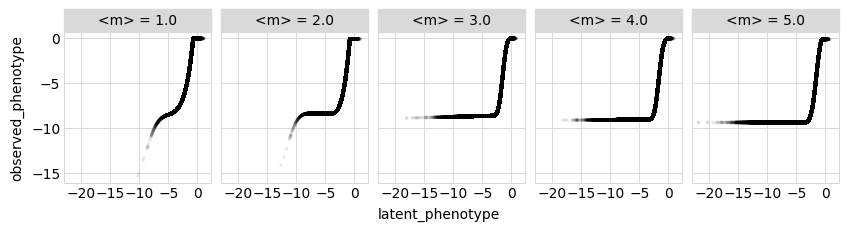

In [26]:
variants_df = pd.concat(
        [model.phenotypes_df.assign(library=library)
         for (epistasis_func, library), model in models.items()
         if epistasis_func == 'global epistasis'],
        ignore_index=True, sort=False)

p = (ggplot(variants_df, aes('latent_phenotype', 'observed_phenotype')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_wrap('~ library', nrow=1) +
     theme(figure_size=(2 * variants_df['library'].nunique(), 2))
     )
_ = p.draw()

## How well do the models infer the latent effects of mutations?
In order to accurately predict the observed phenotypes of unseen variants, it will be important to accurately have inferred the latent effects of mutations.

Here we get the predicted latent effect of each mutation for each library / epistasis function using [AbstractEpistasis.latent_effects_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.latent_effects_df):

In [27]:
latent_df_list = []
for (epistasis_func, library), model in models.items():
    latent_df_list.append(
        model.latent_effects_df
        .rename(columns={'latent_effect': 'predicted_latent_effect'})
        .assign(library=library,
                epistasis_func=epistasis_func)
        )
    
latent_df = pd.concat(latent_df_list, ignore_index=True, sort=False)

Because we simulated the experiments using [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator), we can also get the **true** latent effect of each mutation.
(Obviously in real non-simulated experiments the true latent phenotypes are unknown.)
Below we get these true latent effects:

In [28]:
latent_df = (
    latent_df
    .assign(
        true_latent_effect=lambda x: x['mutation'].map(phenosimulator.muteffects),
        )
    )

Now we calculate the correlations between the true and model-predicted latent effects:

In [29]:
# NBVAL_IGNORE_OUTPUT

latent_corr = (
    latent_df
    .groupby(['library', 'epistasis_func'])
    .apply(lambda x: x['predicted_latent_effect'].corr(x['true_latent_effect']))
    .rename('correlation')
    .to_frame()
    .reset_index()
    .pivot_table(index='library',
                 values='correlation',
                 columns='epistasis_func',
                 )
    )

latent_corr.round(2)

epistasis_func,global epistasis,no epistasis
library,,
<m> = 1.0,0.97,0.95
<m> = 2.0,0.96,0.95
<m> = 3.0,0.94,0.90
<m> = 4.0,0.99,0.85
<m> = 5.0,0.98,0.80


The correlations above show that the global epistasis models do a better job of inferring the latent effects than the no-epistasis model, and that the best inferences are made when the average number of mutations per variant is between 3 and 4.
However, the correlation coefficients don't really do justice to the data, since these correlations are dominate by the very low and very high values.
Below we plot the correlations between the model-predicted and true values.
Those plots make clear that the global epistasis models do a much better job than the no-epistasis models, particularly for the mutation rates of 3 or 4.
When looking at the plots, keep in mind the most critical region is the moderately deleterious to beneficial mutations, since highly deleterious mutations don't really need to have their latent effects inferred accurately other than correctly inferring that they are highly deleterious:

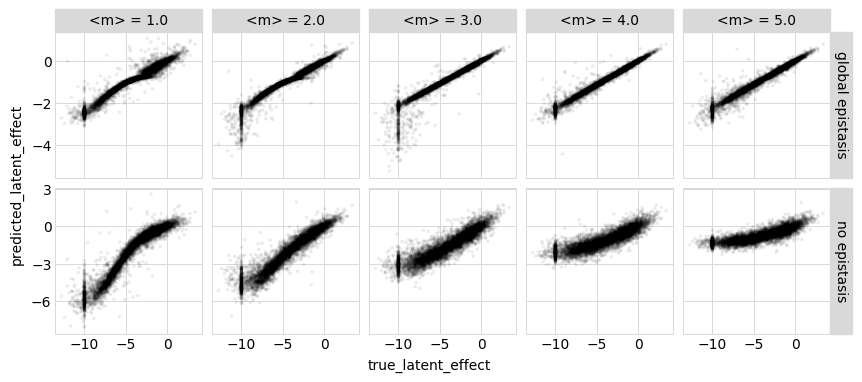

In [32]:
p = (ggplot(latent_df,
            aes('true_latent_effect', 'predicted_latent_effect')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('epistasis_func ~ library', scales='free_y') +
     theme(figure_size=(2 * latent_df['library'].nunique(),
                        2 * latent_df['epistasis_func'].nunique())
           )
     )

_ = p.draw()

## Predict phenotypes of unseen variants
Now we are going to test how well the models can predict the phenotypes of unseen variants that have a modest number of mutations relative to the wildtype sequence used in the experiments.

We will test the predictions in terms of the *enrichment* of the variants after selection (recall this is the exponential of the observed phenotype), since this enrichment is the number that best quantifies how well the unseen variants actually would perform in an experiment.

Below we generate a set of new variants with a modest number of mutations relative to wildtype, and then calculate their *true* enrichment under the simulator used to simulate the experiments above:

In [33]:
nmuts = 4  # predict variants with this many mutations relative to wildtype
npredict = 50000  # make predictions for this many variants

rand_variants_df = (
    pd.DataFrame({'codon_substitutions': dms_variants.simulate.codon_muts(geneseq,
                                                                          nmuts,
                                                                          npredict)
                  })
    .assign(
        aa_substitutions=lambda x: x['codon_substitutions'].map(
                dms_variants.codonvarianttable.CodonVariantTable.codonToAAMuts),
        true_enrichment=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedEnrichment),
        )
    )

Now we calculate the predicted enrichments from the model for these variants.
Note that when calling [AbstractEpistasis.add_phenotypes_to_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.add_phenotypes_to_df), we set the phenotypes of unknown variants to `nan` (unknown variants are ones that contain a mutation that was not observed at all in the set of variants used to fit the modle).
We then drop such variants.

In [34]:
rand_variants_df_list = []
for (epistasis_func, library), model in models.items():
    rand_variants_df_list.append(
        model.add_phenotypes_to_df(rand_variants_df,
                                   latent_phenotype_col='predicted_latent_phenotype',
                                   observed_phenotype_col='predicted_observed_phenotype',
                                   unknown_as_nan=True,
                                   )
        .dropna(axis='index')
        .assign(
            library=library,
            epistasis_func=epistasis_func,
            predicted_enrichment=lambda x: model.enrichments(x['predicted_observed_phenotype']),
            )
        )
rand_variants_df = pd.concat(rand_variants_df_list)

Now look at the correlation between the predicted and true phenotypes for the unseen variants.
We also tally how many variants there are (after dropping the ones with unknown phenotypes) that can be predicted by each model:

In [35]:
# NBVAL_IGNORE_OUTPUT

rand_variants_corr = (
    rand_variants_df
    .groupby(['library', 'epistasis_func'])
    .apply(lambda x: x['predicted_enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .join(rand_variants_df
           .groupby(['library', 'epistasis_func'])
           .size()
           .rename('num_variants')
           )
    .reset_index()
    .pivot_table(index=['library', 'num_variants'],
                 columns='epistasis_func',
                 values='correlation',
                 )
    )

rand_variants_corr.round(2)

,epistasis_func,global epistasis,no epistasis
library,num_variants,,
<m> = 1.0,49919,0.89,0.84
<m> = 2.0,50000,0.95,0.85
<m> = 3.0,50000,0.99,0.75
<m> = 4.0,50000,0.99,0.72
<m> = 5.0,50000,0.98,0.63


The correlation coefficients above shows that the predictions are best using the global epistasis model with between 3 and 4 mutations per variant.
This point becomes even more clear if we look at the actual correlation scatter plots, which are shown below.
(Note that for the plotting we clip predicted enrichments > 2 to 2 to avoid outliers distorting the plot scales):

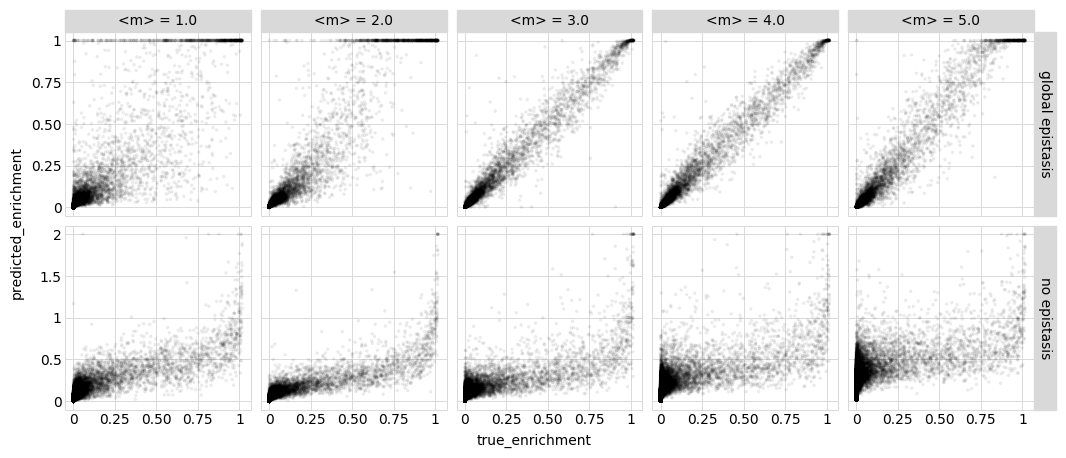

In [40]:
p = (ggplot(rand_variants_df.assign(predicted_enrichment=lambda x:
                                    scipy.clip(x['predicted_enrichment'], None, 2)),
            aes('true_enrichment', 'predicted_enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('epistasis_func ~ library', scales='free_y') +
     theme(figure_size=(2.5 * rand_variants_df['library'].nunique(),
                        2.5 * rand_variants_df['epistasis_func'].nunique(),
                        )
           )
     )

_ = p.draw()

Perhaps even more salient is to look at the predictions only on the variants that are at least somewhat functional.
This is because much of the correlations in the plot above come from the low end of variants with very low enrichments--but those variants are dead so we don't care so much about predicting them.
So below we repeat the analysis after first filtering for variants with at least a modestly high enrichment:

In [37]:
# NBVAL_IGNORE_OUTPUT

rand_variants_filtered_df = rand_variants_df.query('true_enrichment > 0.1')

rand_variants_filtered_corr = (
    rand_variants_filtered_df
    .groupby(['library', 'epistasis_func'])
    .apply(lambda x: x['predicted_enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .join(rand_variants_filtered_df
           .groupby(['library', 'epistasis_func'])
           .size()
           .rename('num_variants')
           )
    .reset_index()
    .pivot_table(index=['library', 'num_variants'],
                 columns='epistasis_func',
                 values='correlation',
                 )
    )

rand_variants_filtered_corr.round(2)

,epistasis_func,global epistasis,no epistasis
library,num_variants,,
<m> = 1.0,2338,0.75,0.67
<m> = 2.0,2343,0.88,0.69
<m> = 3.0,2343,0.96,0.56
<m> = 4.0,2343,0.96,0.55
<m> = 5.0,2343,0.94,0.51


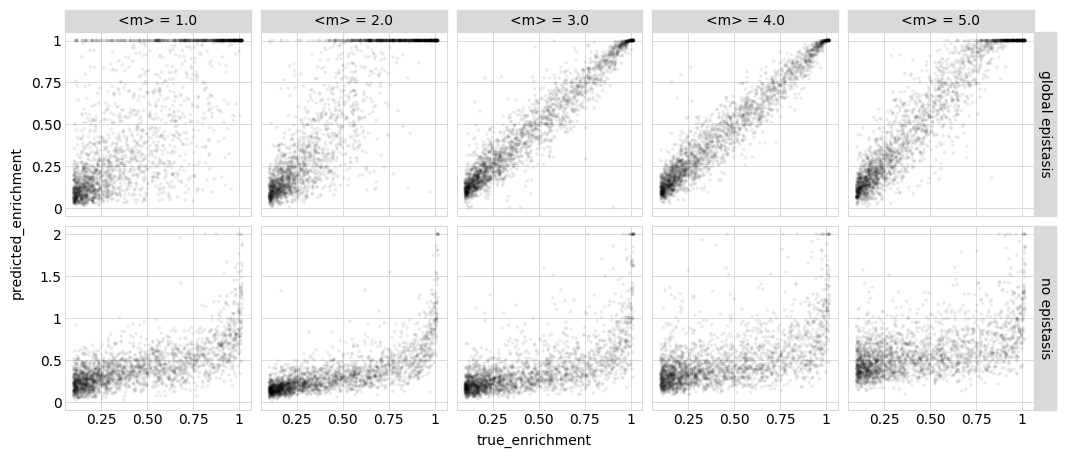

In [42]:
p = (ggplot(rand_variants_filtered_df.assign(predicted_enrichment=lambda x:
                                             scipy.clip(x['predicted_enrichment'], None, 2)),
            aes('true_enrichment', 'predicted_enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('epistasis_func ~ library', scales='free_y') +
     theme(figure_size=(2.5 * rand_variants_df['library'].nunique(),
                        2.5 * rand_variants_df['epistasis_func'].nunique(),
                        )
           )
     )

_ = p.draw()

The table and plot above shows that the superiority of the global epistasis models using libraries with mutation rates between 3 and 4 is even more obvious if we look at the variants filtered for at least some functionality.